In [124]:
import numpy as np
import plotly.express as px
import math
import plotly.figure_factory as ff
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
def simulador(lambda_=1, mi_=2, tempo_total_simulacao=10000, deterministico=False):
    n = tempo_simulacao = num_chegadas = tempo_ocupado_servidor = 0
    clientes_fila, chegadas, freq_clientes, tempo_clientes_fila, tempo_clientes_sistema, tempo_espera_sistema = [], [], [], [], [], []
    
    exponential = (lambda mi: 1 / mi) if deterministico else (lambda mi: np.random.exponential(scale=1 / mi))

    while tempo_simulacao < tempo_total_simulacao:
        tempo_chegada = np.random.exponential(scale=1 / lambda_)
        tempo_saida = exponential(mi_)
        last_event_time = tempo_simulacao

        if n == 0 or tempo_chegada < tempo_saida:
            if n == 0:
                freq_clientes.append(len(clientes_fila))

            tempo_simulacao += tempo_chegada
            num_chegadas += 1
            tempo_clientes_sistema.append((tempo_simulacao - last_event_time) * n)
            tempo_clientes_fila.append((tempo_simulacao - last_event_time) * len(clientes_fila))
            chegadas.append(tempo_simulacao)
            n += 1

            if n > 1:
                clientes_fila.append(tempo_simulacao)
                tempo_ocupado_servidor += tempo_chegada
                freq_clientes.append(len(clientes_fila))

        else:
            tempo_simulacao += tempo_saida
            tempo_clientes_sistema.append((tempo_simulacao - last_event_time) * n)
            tempo_clientes_fila.append((tempo_simulacao - last_event_time) * len(clientes_fila))

            if len(clientes_fila):
                clientes_fila.pop(0)

            tempo_espera_sistema.append(tempo_simulacao - chegadas.pop(0))
            tempo_ocupado_servidor += tempo_saida  
            n -= 1
    
    soma_tempo_clientes_fila = sum(tempo_clientes_fila)
    soma_tempo_clientes_sistema = sum(tempo_clientes_sistema)

    Wq = soma_tempo_clientes_fila / num_chegadas
    W = soma_tempo_clientes_sistema / num_chegadas
    L = soma_tempo_clientes_sistema / tempo_simulacao
    Lq = soma_tempo_clientes_fila / tempo_simulacao
    rho = tempo_ocupado_servidor / tempo_simulacao  
    pi = Counter(freq_clientes)

    for valor, freq in pi.items():
        pi[valor] = round(freq / num_chegadas, 6)

    results = {
        'Total de Clientes': num_chegadas,
        'Clientes Restantes': n,
        'Tempo Total': tempo_simulacao,
        'Tempo Espera Sistema': tempo_espera_sistema,
        'Wq': Wq,
        'W': W,
        'L': L,
        'Lq': Lq,
        'rho': rho,
        'pi': pi,
    }

    return results

In [4]:
def get_z_score(confidence_level):
    if confidence_level == 0.9:
        return 1.645
    elif confidence_level == 0.95:
        return 1.96
    elif confidence_level == 0.99:
        return 2.58

In [5]:
def geo(p,k):
    return (1 - p) * p ** k

In [6]:
def valor_analitico(lambda_, mu_):
    W = 1/(mu_-lambda_)
    Wq = W - (1/mu_)
    L = lambda_*W
    Lq=lambda_*Wq
    Rho = lambda_/mu_
    return [L, Lq, W, W, Rho]

In [122]:
def intervalo_confianca(data, conf_level, sample_size):
    x_barra = np.mean(data)
    z = get_z_score(conf_level)
    s = np.std(data, ddof=1)
    limite_inferior = x_barra - z*s/math.sqrt(sample_size)
    limite_superior = x_barra + z*s/math.sqrt(sample_size)
    return (limite_inferior, limite_superior)

In [123]:
def simulator_confidence_interval(lambda_, mi_, sample_size, conf_level, tempo_total_simulacao = 1000, deterministico=False):
    Wq_data = []
    W_data = []
    L_data = []
    Lq_data = []
    rho_data = []
    pi = {}

    results = [simulador(lambda_, mi_, tempo_total_simulacao) for _ in range(sample_size)]

    for sample in results:
        Wq_data.append(sample['Wq'])
        W_data.append(sample['W'])
        L_data.append(sample['L'])
        Lq_data.append(sample['Lq'])
        rho_data.append(sample['rho'])
        for k, value in sample['pi'].items():
            if k not in pi:
                pi[k] = []
            pi[k].append(value)

    conf_level = 0.95 

    Wq_ic = intervalo_confianca(Wq_data, conf_level, sample_size)
    W_ic = intervalo_confianca(W_data, conf_level, sample_size)
    L_ic = intervalo_confianca(L_data, conf_level, sample_size)
    Lq_ic = intervalo_confianca(Lq_data, conf_level, sample_size)
    rho_ic = intervalo_confianca(rho_data, conf_level, sample_size)

    pi_ic = {i: [] for i in range(len(pi)+1)}
    for k in pi.keys():
        pi_ic[k] = intervalo_confianca(pi[k], conf_level, sample_size)    

    return {'Wq': {'IC': Wq_ic, 'Amostras': Wq_data},
            'W': {'IC': W_ic, 'Amostras': W_data},
            'L': {'IC': L_ic, 'Amostras': L_data},
            'Lq': {'IC': Lq_ic, 'Amostras': Lq_data},
            'rho': {'IC': rho_ic, 'Amostras': rho_data},
            'pi': {'IC': pi_ic, 'Amostras': pi}
            }

In [127]:
def remove_outliers(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1

    upper_bound = q3 + (1.5 * iqr)
    lower_bound = q1 - (1.5 * iqr)

    data_without_outliers = [x for x in data if (x >= lower_bound) and (x <= upper_bound)]

    outlier_percentage = (len(data) - len(data_without_outliers)) / len(data) * 100

    print(f"Porcentagem de outliers removidos: {outlier_percentage} %")

    return data_without_outliers


# M/M/1 Básica e Variantes (20 pontos)

## Cenário 1:  $λ= 1, μ= 2, ρ= 0.5$

In [7]:
result = simulador(lambda_=1, mi_=2, tempo_total_simulacao=10000, deterministico=False)

In [8]:
# Index
indices = ['Tempo médio do cliente no sistema (L)',
           'Tempo médio de cliente na fila (Lq)',
           'Número médio de clientes no sistema (W)',
           'Número médio de clientes na fila (Wq)',
           'Probabilidade do sistema ocupado (p)']

# Valor Simulado
data_simulado = [
        result['L'],
        result['Lq'],
        result['W'],
        result['Wq'],
        result['rho']]

def custom_round(value):
    return round(value, 2)
data_simulado = [custom_round(value) for value in data_simulado]

# Valor Analitico
data_analitico = valor_analitico(1,2)

df = pd.DataFrame({'Simulado': data_simulado, 'Analítico': data_analitico}, index=indices)
df

,Simulado,Analítico
Tempo médio do cliente no sistema (L),1.00,1.0
Tempo médio de cliente na fila (Lq),0.50,0.5
Número médio de clientes no sistema (W),0.99,1.0
Número médio de clientes na fila (Wq),0.49,1.0
Probabilidade do sistema ocupado (p),0.50,0.5


### CDF Número de clientes no sistema

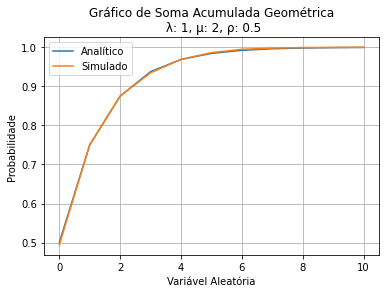

In [9]:
# Valores Simulador
pi = result['pi']
cumulative_sum = np.cumsum(list(pi.values()))

# Valores Analíticos
p = 0.5
x = np.arange(0, len(pi))
y = np.cumsum(geo(p, x))

# Plotagem
plt.plot(x, y, label='Analítico')
plt.plot(result['pi'].keys(), cumulative_sum, label='Simulado')
# plt.fill_between(x, y, cumulative_sum - 5.1, cumulative_sum + 5.1, color='gray', alpha=0.2, label='Intervalo de Confiança (95%)')
plt.xlabel('Variável Aleatória')
plt.ylabel('Probabilidade')
plt.legend()
plt.title(f'Gráfico de Soma Acumulada Geométrica\n λ: {1}, μ: {2}, ρ: {0.5}')
plt.grid(True)
plt.show()


### CDF Tempo de espera dos clientes no sistema (fila de espera + servidor)

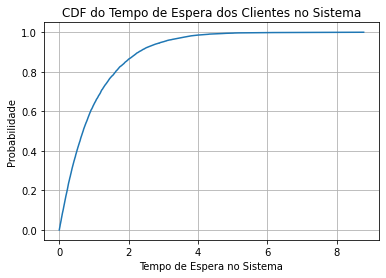

In [11]:
result['Tempo Espera Sistema'].sort()
probabilidade_acumulada = np.arange(1, len(result['Tempo Espera Sistema']) + 1) / len(result['Tempo Espera Sistema'])

plt.plot(result['Tempo Espera Sistema'], probabilidade_acumulada)
plt.xlabel('Tempo de Espera no Sistema')
plt.ylabel('Probabilidade')
plt.title('CDF do Tempo de Espera dos Clientes no Sistema')
plt.grid(True)
plt.show()

## Visualizações e Intervalo de Confiança

Vamos verificar o intervalo de confiança para o tempo médio do cliente no sistema.

In [125]:
data_ic = simulator_confidence_interval(lambda_= 1, mi_= 2, sample_size = 1000, conf_level = 0.95)

In [126]:
for key, value in data_ic['pi']['IC'].items():
    if not value:
        data_ic['pi']['IC'][key] = (np.nan, np.nan)

df = pd.DataFrame(data_ic['pi']['IC']).T
df.columns = ['Limite Inferior', 'Limite Superior']
df = df.dropna(how='all')
df

,Limite Inferior,Limite Superior
0,0.499602,0.503003
1,0.249482,0.251127
2,0.123836,0.125265
3,0.060990,0.062290
4,0.030549,0.031604
5,0.015433,0.016233
6,0.007715,0.008276
7,0.004148,0.004507
8,0.002807,0.003071
9,0.002333,0.002549


### Dados Antigos

In [88]:
fig = ff.create_distplot([data_ic['Lq']['Amostras']], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

In [89]:
fig = px.histogram(data_ic['Lq']['Amostras'], marginal="box")
fig.show()

## Remoção de  outliers

In [92]:
data_without_outliers = remove_outliers(data_ic['Lq']['Amostras'])
fig = ff.create_distplot([data_without_outliers], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

Porcentagem de outliers removidos: 1.5 %
